### Meridional structure of the amplitude of the mean seasonal cycle of PR in the eastern Pacific

Computes the meridional root mean square error (RMSE) of eastern Pacific (15°S-15°N) amplitude (standard deviation) of the mean annual cycle (zonal 150-90°W average) precipitation (PR) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

This notebook computes the meridional root mean square error (RMSE) of the amplitude of the mean seasonal cycle of precipitation (PR) between model simulations and observations over the eastern Pacific region (15°S–15°N, 150°W–90°W).

The analysis involves:

- Zonal Averaging: Averaging precipitation data between 150°W and 90°W for both model output and observations.
- Seasonal Cycle Analysis: Computing the mean annual cycle (12-month time series) at each latitude by averaging monthly precipitation over the analysis period.
- Amplitude Calculation: Determining the standard deviation of the mean annual cycle at each latitude to quantify its amplitude.
- Meridional RMSE: Calculating the RMSE between model and observational amplitudes to evaluate the model's ability to replicate the observed seasonal cycle.

## Observations and reanalysis datasets used for comparison

- **GPCPv2.3 (1979-2018)**: The primary dataset for comparison. The Global Precipitation Climatology Project (GPCP) combines satellite and surface precipitation measurements to provide comprehensive global precipitation data.

These datasets provide a range of perspectives on precipitation patterns, helping to assess the model’s performance more robustly.

## Dask Cluster  
Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client
client = Client() #threads_per_worker = 1?
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45191,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:43851,Total threads: 4
Dashboard: /proxy/43199/status,Memory: 15.83 GiB
Nanny: tcp://127.0.0.1:36909,


2025-08-15 16:11:35,095 - distributed.nanny - WARNING - Restarting worker
2025-08-15 16:12:08,543 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing


In [5]:
# ACCESS MOPPeR ESM1.6
import glob
from access_mopper import ACCESS_ESM_CMORiser

ROOT_FOLDER = (
    "/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/JuneSpinUp-JuneSpinUp-bfaa9c5b/"
)

OUTPUT_FOLDER = "/scratch/nf33/fc6164/"

parent_experiment_config = {
    "parent_experiment_id": "piControl",
    "parent_activity_id": "CMIP",
    "parent_source_id": "ACCESS-ESM1-5",
    "parent_variant_label": "r1i1p1f1",
    "parent_time_units": "days since 0001-01-01 00:00:00",
    "parent_mip_era": "CMIP6",
    "branch_time_in_child": 0.0,
    "branch_time_in_parent": 54786.0,
    "branch_method": "standard",
}

In [7]:
FILES = glob.glob(ROOT_FOLDER + "output[0-4][0-9][0-9]/atmosphere/netCDF/*mon.nc")
len(FILES)

6000

In [6]:
cmoriser = ACCESS_ESM_CMORiser(
    input_paths=FILES,
    compound_name="Amon.pr",
    experiment_id="piControl",
    source_id="ACCESS-ESM1-5",
    variant_label="r1i1p1f1",
    grid_label="gn",
    activity_id="CMIP",
    output_path=OUTPUT_FOLDER,
    parent_info=parent_experiment_config, # <-- This is optional, can be skipped if not needed
    )

In [8]:
cmoriser.run()

In [10]:
cmoriser.to_dataset()

<xarray.Dataset> Size: 701MB
Dimensions:    (lat: 145, time: 6000, bnds: 2, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time       (time) float64 48kB 4.991e+05 4.992e+05 ... 5.739e+05 5.739e+05
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float64 14MB dask.array<chunksize=(1, 145, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 18MB dask.array<chunksize=(1, 192, 2), meta=np.ndarray>
    time_bnds  (time, bnds) float64 96kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    pr         (lon, lat, time) float32 668MB dask.array<chunksize=(192, 145, 1), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    creation_date:          2025-08-15T05:34:35Z
    data_specs_version:     01.00.33
    experiment:             pre-industrial control
    experiment_id:          piControl
    ...                     ...
    branch_method:          standard
    external_variables:     areacella
    creator_name:           felicity Chun
    creator_organisation:   ACCESS-NRI
    creator_email:          felicity.chun@anu.edu.au
    creator_url:            0009-0007-0845-0953

In [ ]:
cmoriser.write()

In [ ]:
esm16 = cmoriser.to_iris() #No module named 'iris.experimental.xarray'
from ncdata.iris_xarray import cubes_from_xarray, cubes_to_xarray # install ncdata
# cubes = cubes_from_xarray(dataset)
# xrds = cubes_to_xarray(cubes)

In [ ]:
import xarray as xr

ds = cmoriser.to_dataset()
for var, val in ds.data_vars.items():
    if var == 'pr':
        darray = val # Dask graph	6000 chunks in 12002 graph layers
        # save bnds? to apply to coords 
        # cube.coord('latitiude').bounds = 

darray = darray.sortby('time') ## rechunk?
esm16_cube = darray.to_iris()

## Datasets

In [23]:
from esmvalcore.dataset import Dataset

In [31]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="piControl",
    ensemble="r1i1p1f1",
    # timerange="18500101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    timerange="19790101/20190101",
    tier=2),
}

## Add Ancillary files


In [32]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [33]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/iris/common/mixin.py:195: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)
(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/sftlf/gn/v20210316/sftlf_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc)
/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/iris/common/mixin.py:195: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings

In [27]:
from esmvalcore.preprocessor import zonal_statistics
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import climate_statistics

import iris
import numpy as np

In [34]:
def preproc1(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    # cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = mask_landsea(cube, mask_out="land")
    cube = convert_units(cube, units="mm/day")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    return cube

def preproc2(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    # cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    cube = zonal_statistics(cube, 'mean')
    
    return cube

# rmse calc from obs
def rmse(obs_cube, model_cube):
    return np.sqrt(np.mean((obs_cube.data - model_cube.data) ** 2))

In [35]:
model_datasets_prep1 = {name: preproc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: preproc1(dataset) for name, dataset in obs_datasets.items()}

esm16_prep1 = preproc1(esm16_cube)

model_datasets_prep2 = {name: preproc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: preproc2(dataset) for name, dataset in obs_datasets.items()}
esm16_prep2 = preproc2(esm16_cube)

/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/iris/common/mixin.py:195: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)
/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/iris/common/mixin.py:195: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)
/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/iris/common/mixin.py:195: FutureWarning: Yo

## Diagnostics Level 1

2025-08-15 16:11:35,231 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:43851 -> tcp://127.0.0.1:35283
Traceback (most recent call last):
  File "/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/tm70/fc6164/conda/envs/esmvaltool_dev/lib/python3.11/site-packages/distributed/worker.py", line 1780, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^

Text(0.5, 0, 'Latitude')

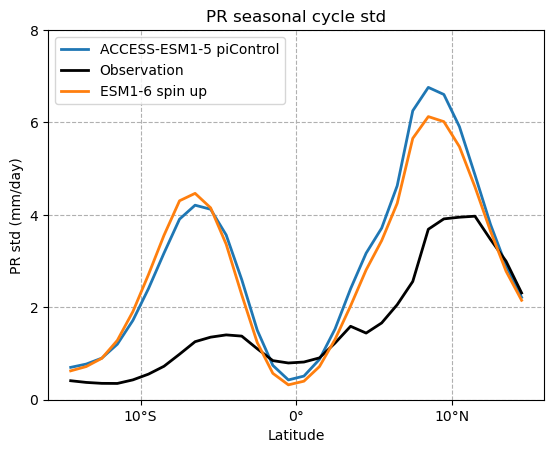

In [37]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt

#plot 1
def format_latitude(x):
    if x < 0:
        return f'{abs(x)}°S'
    elif x > 0:
        return f'{x}°N'
    else:
        return '0°'

obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]
error = rmse(obs_data, model_data)

qplt.plot(model_data, label='ACCESS-ESM1-5 piControl', linewidth=2)
qplt.plot(obs_data, color='black', label='Observation', linewidth=2)
qplt.plot(esm16_prep2, label='ESM1-6 spin up', linewidth=2)

# plt.text(0.5, 0.95, f'RMSE: {error:.2f}', fontsize=12, ha='center', transform=plt.gca().transAxes,
#          bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.legend()
# ax = plt.gca()
plt.grid(linestyle='--')
plt.title('PR seasonal cycle std')

plt.yticks(np.arange(0,9, step=2))
plt.ylabel('PR std (mm/day)')

xt = np.arange(-10,15,step=10)
xlab = [format_latitude(x) for x in xt]
plt.xticks(xt,xlab)
plt.xlabel('Latitude')

Figure 1: Meridional bias in the amplitude of the mean seasonal precipitation cycle (PR) in the eastern Pacific (averaged between 150–90°W). The black curve represents the reference data, while the blue curve represents the model data. The metric shown is the meridional RMSE between the model and reference curves.

## Diagnostics level 2

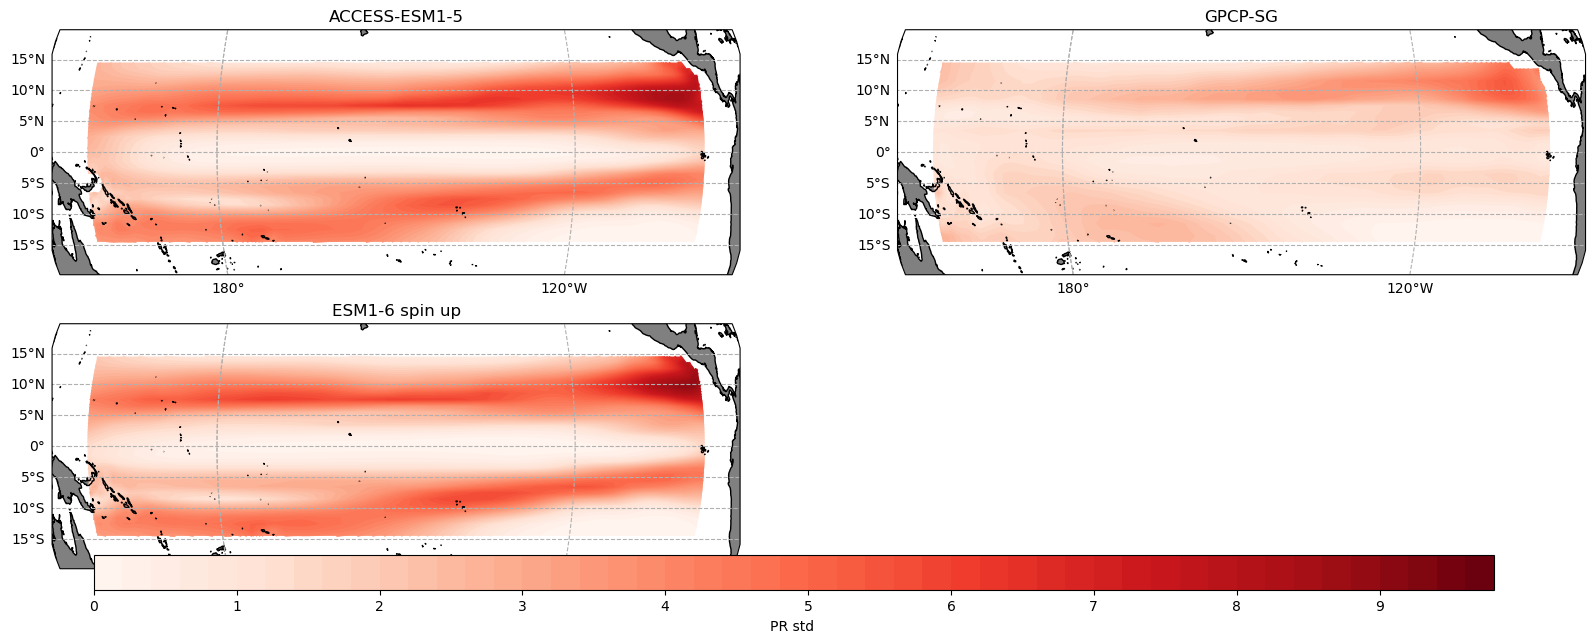

In [38]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =221
process = {**model_datasets_prep1, **obs_datasets_prep1, 'ESM1-6 spin up': esm16_prep1}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,10,0.2), cmap='Reds')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,10,1))
cbar.set_label('PR std ')

Figure 2: Bias in the amplitude of the mean seasonal cycle of precipitation (PR) in the equatorial Pacific. The left map shows the reference data, while the right map displays the model data.

# Diagnostic level 3

The third level shows the meridional structure of the mean seasonal cycle in a Hovmöller diagram

In [11]:
def preproc3(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = zonal_statistics(cube, operator='mean')
    
    return cube

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}
process = {**model_datasets_prep3, **obs_datasets_prep3}

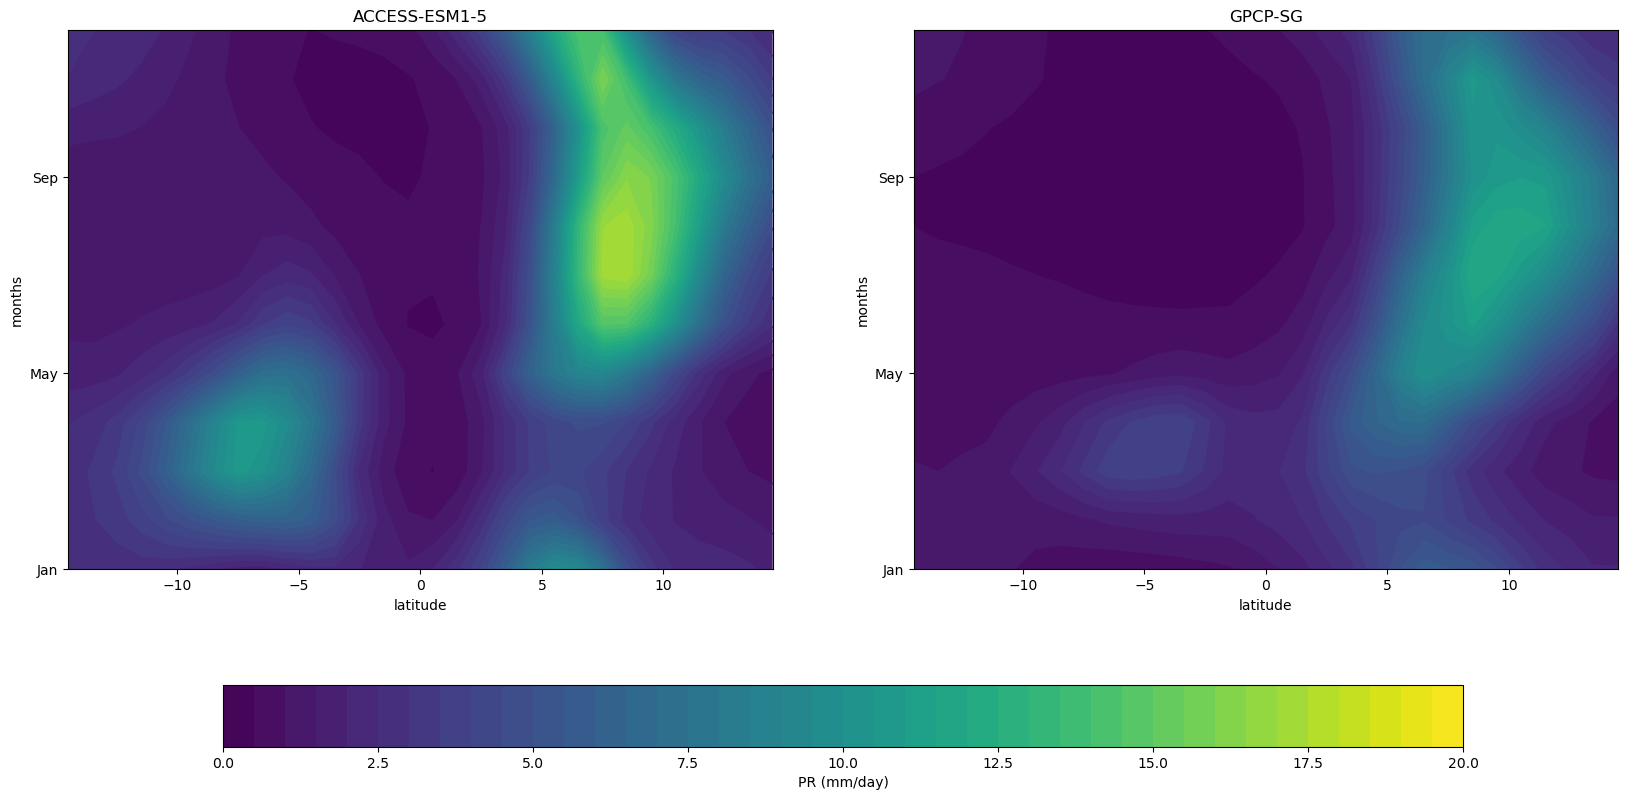

In [ ]:
fig = plt.figure(figsize=(10, 6))
i=121

# Define tick positions and labels for the y-axis (months)
month_ticks = np.arange(1, 13, 4)
month_labels =['Jan', 'May', 'Sep'] 
# ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                # 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['latitude','month_number'],levels=np.arange(0,20.5,0.5),cmap="viridis")
    ax1.set_ylim(1, 12)
    ax1.set_yticks(ticks=month_ticks, labels=month_labels)
    ax1.set_title(label)
    ax1.set_ylabel("months")
    ax1.set_xlabel("latitude")
    axls.append(ax1)
    i+=1

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')
cbar.set_label('PR (mm/day)')

Figure 3: Meridional structure of the mean seasonal cycle of precipitation (PR) in the eastern Pacific (averaged between 150–90°W). The left map represents the reference data, while the right map shows the model data.